# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 21, 46, 7, 717075)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# with open('./data/hopsworks-api-key.txt', 'r') as file:
#    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157269
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=6,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.9173325E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date'], ascending=True).reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-19 00:00:00+00:00,4.45,0.0,7.280550,351.469299,amsterdam
1,2024-11-20 00:00:00+00:00,3.75,0.5,22.007162,273.751648,amsterdam
2,2024-11-21 00:00:00+00:00,1.85,0.1,7.628263,199.290146,amsterdam
3,2024-11-22 00:00:00+00:00,3.75,0.1,17.462784,261.702942,amsterdam
4,2024-11-23 00:00:00+00:00,2.30,0.0,12.303366,159.443878,amsterdam
5,2024-11-24 00:00:00+00:00,12.50,0.5,33.402489,210.434158,amsterdam
6,2024-11-25 00:00:00+00:00,10.25,0.1,35.320385,240.037903,amsterdam
7,2024-11-26 00:00:00+00:00,7.85,0.1,14.417988,267.137665,amsterdam
8,2024-11-27 00:00:00+00:00,5.45,0.0,11.631956,111.801476,amsterdam


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

air_quality_df = air_quality_fg.read()

# Extract only the date part (remove time) from the 'date' column
air_quality_df['date'] = air_quality_df['date'].dt.date
today_date = today.date()
aq_today_df = air_quality_df[air_quality_df['date'] == today_date]
aq_today_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
3195,2024-11-18,15.0,18.0,52.0,33.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670


In [9]:
batch_data['pm25_lag_1'] = aq_today_df['pm25'].iloc[0]
batch_data['pm25_lag_2'] = aq_today_df['pm25_lag_1'].iloc[0]
batch_data['pm25_lag_3'] = aq_today_df['pm25_lag_2'].iloc[0]
batch_data['predicted_pm25'] = 0
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2024-11-19 00:00:00+00:00,4.45,0.0,7.280550,351.469299,amsterdam,15.0,18.0,52.0,0
1,2024-11-20 00:00:00+00:00,3.75,0.5,22.007162,273.751648,amsterdam,15.0,18.0,52.0,0
2,2024-11-21 00:00:00+00:00,1.85,0.1,7.628263,199.290146,amsterdam,15.0,18.0,52.0,0
3,2024-11-22 00:00:00+00:00,3.75,0.1,17.462784,261.702942,amsterdam,15.0,18.0,52.0,0
4,2024-11-23 00:00:00+00:00,2.30,0.0,12.303366,159.443878,amsterdam,15.0,18.0,52.0,0
5,2024-11-24 00:00:00+00:00,12.50,0.5,33.402489,210.434158,amsterdam,15.0,18.0,52.0,0
6,2024-11-25 00:00:00+00:00,10.25,0.1,35.320385,240.037903,amsterdam,15.0,18.0,52.0,0
7,2024-11-26 00:00:00+00:00,7.85,0.1,14.417988,267.137665,amsterdam,15.0,18.0,52.0,0
8,2024-11-27 00:00:00+00:00,5.45,0.0,11.631956,111.801476,amsterdam,15.0,18.0,52.0,0


In [ ]:
days_ahead = len(batch_data.index)
for day_ahead in range(len(batch_data.index)):

    # Extract the features for the day ahead
    predicted_day = batch_data.iloc[day_ahead]

    # Predict the PM2.5 value for the day ahead
    predicted_value = retrieved_xgboost_model.predict(predicted_day[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                                                                     'wind_direction_10m_dominant', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']].values.reshape(1, -1))[0]

    # Update the predicted PM2.5 value in the dataframe
    batch_data.loc[day_ahead, 'predicted_pm25'] = predicted_value

    # Update the lag features for the next prediction (if not the last day)
    if day_ahead < days_ahead - 1:
        batch_data.loc[day_ahead + 1, 'pm25_lag_3'] = batch_data.loc[day_ahead, 'pm25_lag_2']
        batch_data.loc[day_ahead + 1, 'pm25_lag_2'] = batch_data.loc[day_ahead, 'pm25_lag_1']
        batch_data.loc[day_ahead + 1, 'pm25_lag_1'] = batch_data.loc[day_ahead, 'predicted_pm25']

batch_data

2024-11-18 21:46:29,027 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '48.54518508911133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2024-11-19 00:00:00+00:00,4.45,0.0,7.280550,351.469299,amsterdam,15.000000,18.000000,52.000000,48.545185
1,2024-11-20 00:00:00+00:00,3.75,0.5,22.007162,273.751648,amsterdam,48.545185,15.000000,18.000000,53.530663
2,2024-11-21 00:00:00+00:00,1.85,0.1,7.628263,199.290146,amsterdam,53.530663,48.545185,15.000000,53.631435
3,2024-11-22 00:00:00+00:00,3.75,0.1,17.462784,261.702942,amsterdam,53.631435,53.530663,48.545185,51.627205
4,2024-11-23 00:00:00+00:00,2.30,0.0,12.303366,159.443878,amsterdam,51.627205,53.631435,53.530663,46.512341
5,2024-11-24 00:00:00+00:00,12.50,0.5,33.402489,210.434158,amsterdam,46.512341,51.627205,53.631435,28.494959
6,2024-11-25 00:00:00+00:00,10.25,0.1,35.320385,240.037903,amsterdam,28.494959,46.512341,51.627205,37.482147
7,2024-11-26 00:00:00+00:00,7.85,0.1,14.417988,267.137665,amsterdam,37.482147,28.494959,46.512341,47.555573
8,2024-11-27 00:00:00+00:00,5.45,0.0,11.631956,111.801476,amsterdam,47.555573,37.482147,28.494959,41.696457


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float32            
 7   pm25_lag_2                   9 non-null      float32            
 8   pm25_lag_3                   9 non-null      float32            
 9   predicted_pm25               9 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(7), float64(1), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,4.45,0.0,7.280550,351.469299,amsterdam,15.000000,18.000000,52.000000,48.545185,vondelpark,netherlands,1
1,2024-11-20 00:00:00+00:00,3.75,0.5,22.007162,273.751648,amsterdam,48.545185,15.000000,18.000000,53.530663,vondelpark,netherlands,2
2,2024-11-21 00:00:00+00:00,1.85,0.1,7.628263,199.290146,amsterdam,53.530663,48.545185,15.000000,53.631435,vondelpark,netherlands,3
3,2024-11-22 00:00:00+00:00,3.75,0.1,17.462784,261.702942,amsterdam,53.631435,53.530663,48.545185,51.627205,vondelpark,netherlands,4
4,2024-11-23 00:00:00+00:00,2.30,0.0,12.303366,159.443878,amsterdam,51.627205,53.631435,53.530663,46.512341,vondelpark,netherlands,5
5,2024-11-24 00:00:00+00:00,12.50,0.5,33.402489,210.434158,amsterdam,46.512341,51.627205,53.631435,28.494959,vondelpark,netherlands,6
6,2024-11-25 00:00:00+00:00,10.25,0.1,35.320385,240.037903,amsterdam,28.494959,46.512341,51.627205,37.482147,vondelpark,netherlands,7
7,2024-11-26 00:00:00+00:00,7.85,0.1,14.417988,267.137665,amsterdam,37.482147,28.494959,46.512341,47.555573,vondelpark,netherlands,8
8,2024-11-27 00:00:00+00:00,5.45,0.0,11.631956,111.801476,amsterdam,47.555573,37.482147,28.494959,41.696457,vondelpark,netherlands,9


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float32            
 7   pm25_lag_2                   9 non-null      float32            
 8   pm25_lag_3                   9 non-null      float32            
 9   predicted_pm25               9 non-null      float64            
 10  street                       9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-18 21:47:04,576 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



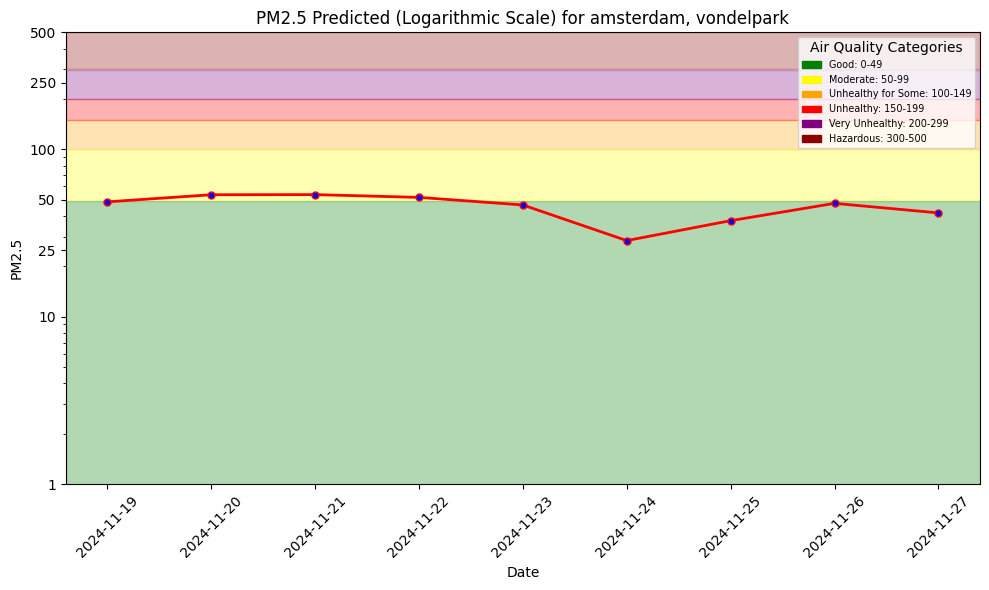

In [ ]:
file_path = "./docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157269/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x31ab12550>, None)

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.46s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,4.4500,0.0,7.280550,351.469299,amsterdam,15.000000,18.00000,52.0,48.545185,vondelpark,netherlands,1
1,2024-11-16 00:00:00+00:00,10.0655,3.2,16.564890,233.002686,amsterdam,52.000000,33.00000,22.0,53.100960,vondelpark,netherlands,1
2,2024-11-17 00:00:00+00:00,8.0000,0.3,23.400002,284.250061,amsterdam,53.100960,52.00000,33.0,32.969482,vondelpark,netherlands,1
3,2024-11-18 00:00:00+00:00,7.8000,0.0,13.358861,284.036255,amsterdam,32.969482,53.10096,52.0,32.754303,vondelpark,netherlands,1


In [21]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2018-05-04 00:00:00+00:00,19.0,22.0,34.0,16.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
1,2022-09-12 00:00:00+00:00,47.0,46.0,30.0,22.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
2,2014-12-14 00:00:00+00:00,49.0,23.0,24.0,23.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
3,2019-01-26 00:00:00+00:00,18.0,93.0,115.0,74.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
4,2021-12-17 00:00:00+00:00,27.0,44.0,38.0,45.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
...,...,...,...,...,...,...,...,...,...
3192,2023-01-20 00:00:00+00:00,58.0,18.0,26.0,25.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
3193,2018-09-21 00:00:00+00:00,16.0,28.0,26.0,39.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
3194,2015-12-12 00:00:00+00:00,27.0,32.0,44.0,30.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670
3195,2024-11-18 00:00:00+00:00,15.0,18.0,52.0,33.0,netherlands,amsterdam,vondelpark,https://api.waqi.info/feed/@2670


In [22]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# This only happens when the feature store is empty, which is only the case when the feature store is created for the first time
if len(hindcast_df) == 0: # 
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-16 00:00:00+00:00,53.100960,52.0
1,2024-11-17 00:00:00+00:00,32.969482,18.0
2,2024-11-18 00:00:00+00:00,32.754303,15.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

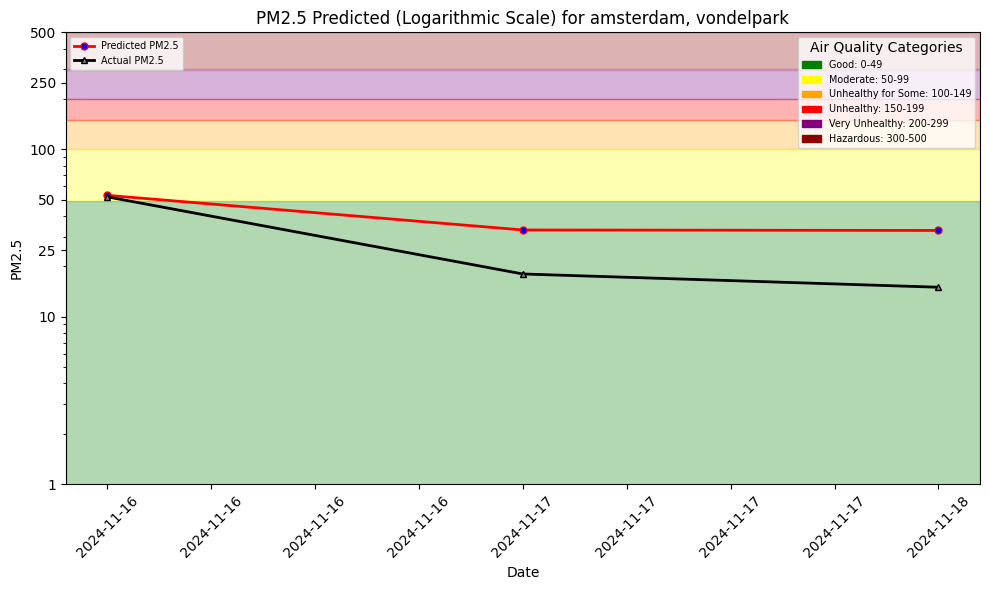

In [ ]:
file_path = "./docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---